In [3]:
import gc
from desom.som_layer import SOMLayer
from desom.autoencoder import conv2d_autoencoder
from desom.datasets import load_data

import tensorflow as tf
from keras.models import Model, Sequential
from keras.metrics import Mean, MeanAbsoluteError

import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import xarray as xr
import multiprocessing

%load_ext autoreload
%autoreload 2

# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
from plots import *
from Experiment import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
from keras.metrics import Mean
from keras.losses import binary_crossentropy
class DESOM(Model):
    def __init__(self, encoder, decoder, som_layer, factors=None, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.som_layer = som_layer
        if factors is None:
            factors = [1, 0.1, 1]
        self.factors = factors
        self.total_loss_tracker = Mean(name="total_loss")
        self.reconstruction_loss_tracker = Mean(
            name="reconstruction_loss"
        )
        self.orthogonal_loss_tracker = Mean(name="orthogonal_loss")
        self.som_loss_tracker = Mean(name="som_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.orthogonal_loss_tracker,
            self.som_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z = self.encoder(data)
            som_loss = self.som_layer(z)
            reconstruction = self.decoder(z)
            # reconstruction_loss = tf.reduce_mean(
            #     tf.reduce_sum(
            #         binary_crossentropy(data, reconstruction), axis=(1, 2)
            #     )
            # )
            reconstruction_loss = tf.reduce_mean(
                tf.math.reduce_euclidean_norm(
                    data - reconstruction, axis=(1, 2)
                )
            )
            embeddings = self.decoder(tf.eye(self.decoder.input.shape[-1]))
            embeddings = tf.reshape(embeddings, (embeddings.shape[0], -1))
            orthogonal_loss = tf.reduce_sum(tf.square(embeddings @ tf.transpose(embeddings) - tf.eye(embeddings.shape[0])))
            total_loss = self.factors[0] * reconstruction_loss + self.factors[1] * orthogonal_loss + self.factors[2] * som_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.orthogonal_loss_tracker.update_state(orthogonal_loss)
        self.som_loss_tracker.update_state(som_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "orthogonal_loss": self.orthogonal_loss_tracker.result(),
            "som_loss": self.som_loss_tracker.result(),
        }

In [22]:
da = xr.open_dataarray('/Users/bandelol/Library/CloudStorage/OneDrive-UniversitaetBern/Documents/GIUB/code/z_anom.nc')
X = da.sel(time=da.time.dt.season=='JJA').values
X = X.reshape(*X.shape, 1)
map_size = (6, 6)
latent_dim = 30
input_shape = X.shape[1:]
encoder, decoder = conv2d_autoencoder(input_shape, latent_dim, [64, 32, 16], 3, 2, 2, 'stretch', batchnorm=True)
som_layer = SOMLayer(map_size, name='som')

In [23]:
epochs = 2
batch_size = 32
save_dir = 'results/tmp'
save_file_ae = Path(f'{save_dir}/ae_weights-epoch{epochs}.h5')

desom = DESOM(encoder, decoder, som_layer, factors=[1, 0.1, 0])
desom.layers[-1].trainable = False
desom.compile()
desom.fit(X, epochs=epochs, batch_size=batch_size)

Epoch 1/2


2023-08-02 13:29:13.904574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


182/182 [==============================] - 103s 545ms/step - loss: 466142213.4208 - reconstruction_loss: 9566.4062 - orthogonal_loss: 1030720960.0000 - som_loss: 565391.9375
Epoch 2/2
182/182 [==============================] - 131s 719ms/step - loss: 9581.4380 - reconstruction_loss: 9573.1074 - orthogonal_loss: 256.9289 - som_loss: 946657.7500


In [24]:
desom.layers[-1].trainable = True
desom.factors = [1, 0.1, 2]
desom.compile()
desom.fit(X, epochs=epochs, batch_size=batch_size)

Epoch 1/2


2023-08-02 13:33:12.638435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


182/182 [==============================] - 154s 838ms/step - loss: 99201.2163 - reconstruction_loss: 9568.5518 - orthogonal_loss: 27.1998 - som_loss: 8406.5986
Epoch 2/2
182/182 [==============================] - 155s 849ms/step - loss: 9601.1729 - reconstruction_loss: 9529.1748 - orthogonal_loss: 26.0784 - som_loss: 3.1435


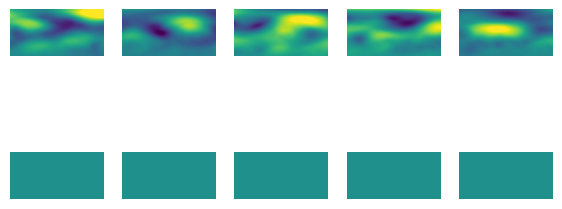

In [25]:
fig, axes = plt.subplots(2, 5, figsize=(7, 3.4))
indices = np.random.randint(0, X.shape[0], size=5)
theseX = X[indices]
theseXp = desom.decoder(desom.encoder(theseX))
for i, j in enumerate(indices):
    axes[0, i].imshow(theseX[i, :, :, 0], origin='lower', vmin=-150, vmax=150)
    axes[1, i].imshow(theseXp[i, :, :, 0], origin='lower', vmin=-150, vmax=150)
    for k in range(2):
        axes[k, i].axis('off')

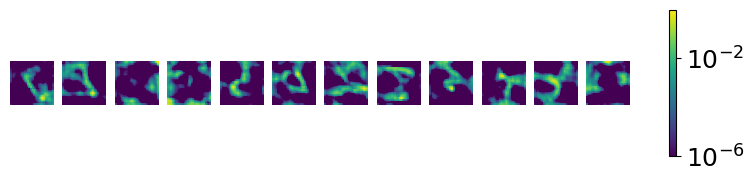

In [53]:
from matplotlib.colors import LogNorm


fig, axes = plt.subplots(1, latent_dim, figsize=(10, 1.9))
theseX = desom.decoder(np.eye(latent_dim))
for i, x in enumerate(theseX):
    im = axes[i].imshow(x[:, :, 0], origin='lower', norm=LogNorm(1e-6, 1))
    axes[i].axis('off')
fig.colorbar(im, ax=axes)

In [54]:
decoded_som_weights = desom.decoder(desom.som_layer.weights)

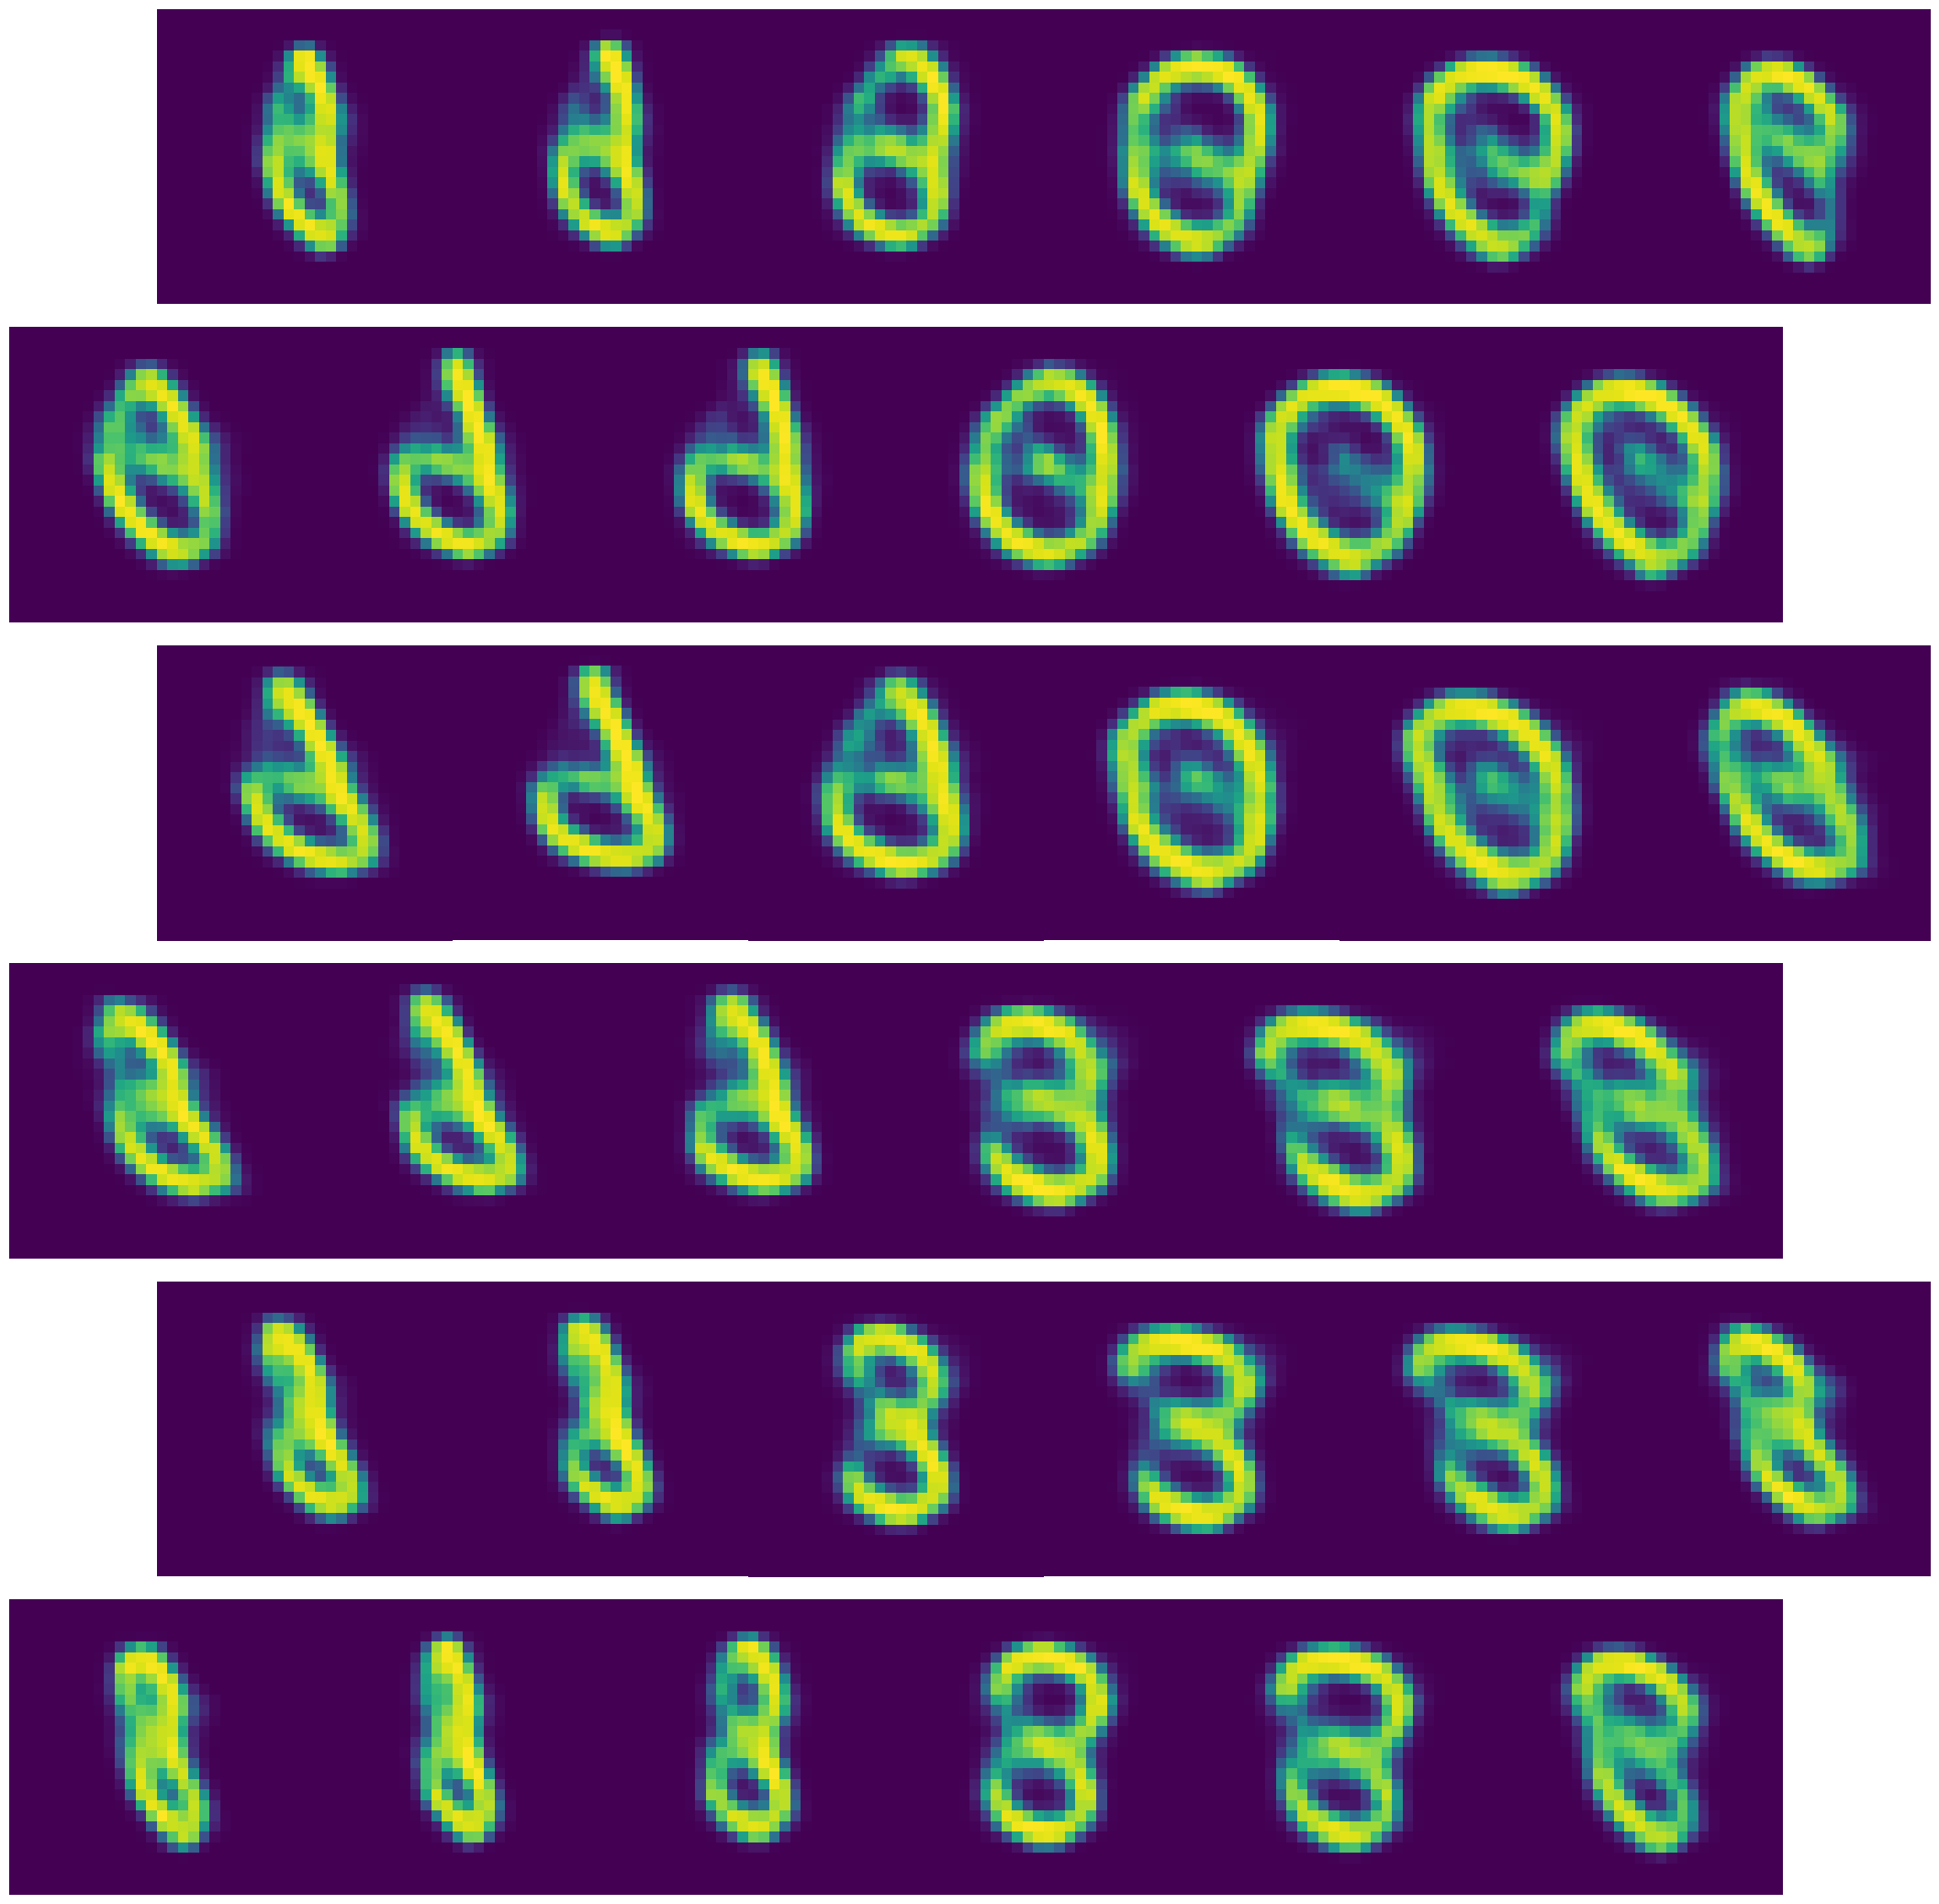

In [55]:
fig, axes = honeycomb_panel(*map_size, ratio=1)
for im, ax in zip(decoded_som_weights, axes.ravel()):
    hehe = ax.imshow(im, cmap='viridis', origin='lower')
    ax.axis('off')
